# Tutorial: Gaussian pulse initial data for a massless scalar field in spherical-like coordinates

## Authors: Leonardo Werneck and Zach Etienne

# This tutorial notebook explains how to obtain time-symmetric initial data for the problem of gravitational collapse of a massless scalar field. We will be following the approaches of [Akbarian & Choptuik (2015)](https://arxiv.org/pdf/1508.01614.pdf) and [Baumgarte (2018)](https://arxiv.org/pdf/1807.10342.pdf).

**Notebook Status**: <font color='green'><b> Validated </b></font>

**Validation Notes**: The initial data generated by the NRPy+ module corresponding to this tutorial notebook are used shown to satisfy Einstein's equations as expected [in this tutorial notebook](Tutorial-Start_to_Finish-BSSNCurvilinear-Setting_up_ScalarField_initial_data.ipynb).</font>

## Python module which performs the procedure described in this tutorial: [ScalarField/ScalarField_InitialData.py](../edit/ScalarField/ScalarField_InitialData.py)

## References

* [Akbarian & Choptuik (2015)](https://arxiv.org/pdf/1508.01614.pdf) (Useful to understand the theoretical framework)
* [Baumgarte (2018)](https://arxiv.org/pdf/1807.10342.pdf) (Useful to understand the theoretical framework)
* [Baumgarte & Shapiro's Numerical Relativity](https://books.google.com.br/books/about/Numerical_Relativity.html?id=dxU1OEinvRUC&redir_esc=y): Section 6.2.2 (Useful to understand how to solve the Hamiltonian constraint)

<a id='toc'></a>

# Table of Contents
$$\label{toc}$$
    
1. [Step 1](#initial_data) Setting up time-symmetric initial data
    1. [Step 1.a](#id_time_symmetry) Time symmetry: $\tilde{K}_{ij}$, $\tilde K$, $\tilde\beta^{i}$, and $\tilde B^{i}$
    1. [Step 1.b](#id_sf_ic) The scalar field initial condition: $\tilde{\varphi}$, $\tilde{\Phi}$, $\tilde{\Pi}$
    1. [Step 1.c](#id_metric) The physical metric: $\tilde{\gamma}_{ij}$
        1. [Step 1.c.i](#id_conformal_metric) The conformal metric $\bar\gamma_{ij}$
        1. [Step 1.c.ii](#id_hamiltonian_constraint) Solving the Hamiltonian constraint
            1. [Step 1.c.ii.1](#id_tridiagonal_matrix) The tridiagonal matrix: $A$
            1. [Step 1.c.ii.2](#id_tridiagonal_rhs) The right-hand side of the linear system: $\vec{s}$
            1. [Step 1.c.ii.3](#id_conformal_factor) The conformal factor: $\psi$
    1. [Step 1.d](#id_lapse_function) The lapse function: $\tilde{\alpha}$
    1. [Step 1.e](#id_output) Outputting the initial data to file
1. [Step 2](#id_interpolation_files) Interpolating the initial data file as needed
1. [Step 3](#id_sph_to_curvilinear) Converting Spherical initial data to Curvilinear initial data
1. [Step 4](#validation) Validation of this tutorial against the [ScalarField/ScalarField_InitialData.py](../edit/ScalarField/ScalarField_InitialData.py) module
1. [Step 5](#output_to_pdf) Output this module as $\LaTeX$-formatted PDF file

<a id='initial_data'></a>

# Step 1: Setting up time-symmetric initial data \[Back to [top](#toc)\]
$$\label{initial_data}$$

In this section we will set up time symmetric initial data for the gravitational collapse of a massless scalar field, in spherical coordinates. Our discussion will follow closely section III.A of [Akbarian & Choptuik (2015)](https://arxiv.org/pdf/1508.01614.pdf) (henceforth A&C). We will be using a *uniform* radial sampling. All initial data quantities will be written with tildes over them, meaning that, for example, $\tilde{\alpha} \equiv \alpha(0,r)$.

<a id='id_time_symmetry'></a>

## Step 1.a: Time symmetry: $\tilde{K}_{ij}$, $\tilde K$, $\tilde\beta^{i}$, and $\tilde B^{i}$ \[Back to [top](#toc)\]
$$\label{id_time_symmetry}$$

We are here considering a spherically symmetric problem, so that $f=f(t,r)$, for every function discussed in this tutorial. The demand for time-symmetric initial data then imples that

\begin{align}
\tilde K_{ij} &= 0\ ,\\
\tilde K &= 0\ ,\\
\tilde \beta^{i} &= 0\ ,\\
\tilde B^{i} &= 0\ .
\end{align}

For the scalar field, $\varphi$, it also demands

$$
\partial_{t}\varphi(0,r) = 0\ ,
$$

which we discuss below.

<a id='id_sf_ic'></a>

## Step 1.b: The scalar field initial condition: $\tilde{\varphi}$, $\tilde{\Phi}$, $\tilde{\Pi}$ \[Back to [top](#toc)\]
$$\label{id_sf_ic}$$

We will be implementing the following options for the initial profile of the scalar field

$$
\begin{aligned}
\tilde{\varphi}_{\rm I}   &= \varphi_{0}\exp\left(-\frac{r^{2}}{\sigma^{2}}\right)\ ,\\
\tilde{\varphi}_{\rm II}  &= \varphi_{0}r^{3}\exp\left[-\left(\frac{r-r_{0}}{\sigma}\right)^{2}\right]\ ,\\
\tilde{\varphi}_{\rm III} &= \varphi_{0}\left\{1 - \tanh\left[\left(\frac{r-r_{0}}{\sigma}\right)^{2}\right]\right\}.
\end{aligned}
$$

We introduce the two auxiliary fields

$$
\tilde\Phi\equiv\partial_{r}\tilde\varphi\quad \text{and}\quad \Pi\equiv-\frac{1}{\alpha}\left(\partial_{t}\varphi - \beta^{i}\partial_{i}\varphi\right)\ ,
$$

of which $\tilde\Phi$ will only be used as an auxiliary variable for setting the initial data, but $\Pi$ is a dynamical variable which will be evolved in time. Because we are setting time-symmetric initial data, $\partial_{t}\sf = 0 = \beta^{i}$, and thus $\tilde\Pi=0$.

In [1]:
import os,sys,shutil
import numpy as np
import sympy as sp
import cmdline_helper as cmd

Ccodesdir = "ScalarFieldID_validation"
shutil.rmtree(Ccodesdir, ignore_errors=True)
cmd.mkdir(Ccodesdir)

###################################################################
# Part A.1: Setting up the initial condition for the scalar field #
###################################################################

# Part A.1a: set up the necessary variables: number of radial points = NR
#                                            the radial variable rr in [0,RMAX],
#                                            \varphi(0,r) = ID_sf     (for scalar field),
#                                            \Phi(0,r)    = ID_sf_dD0 (for the radial derivative of sf) ,
#                                            \Pi(0,r)     = ID_sfM    (for scalar field conjutage Momentum).
RMAX        = 50
NR          = 30000
# Available options are: Gaussian_pulse, Gaussian_pulsev2, and Tanh_pulse
ID_Family   = "Gaussian_pulsev2"
CoordSystem = "Spherical"
sinhA       = RMAX
sinhW       = 0.1

if CoordSystem == "Spherical":
    r  = np.linspace(0,RMAX,NR+1) # Set the r array
    dr = np.zeros(NR)
    for i in range(NR):
        dr[i] = r[1]-r[0]
    r  = np.delete(r-dr[0]/2,0)      # Shift the vector by -dr/2 and remove the negative entry
elif CoordSystem == "SinhSpherical":
    if sinhA == None or sinhW == None:
        print("Error: SinhSpherical coordinates require initialization of both sinhA and sinhW")
        sys.exit(1)
    else:
        x  = np.linspace(0,1.0,NR+1)
        dx = 1.0/(NR+1)
        x  = np.delete(x-dx/2,0)      # Shift the vector by -dx/2 and remove the negative entry
        r  = sinhA * np.sinh( x/sinhW ) / np.sinh( 1.0/sinhW )
        dr = sinhA * np.cosh( x/sinhW ) / np.sinh( 1.0/sinhW ) * dx
else:
    print("Error: Unknown coordinate system")
    sys.exit(1)

# Set the step size squared
dr2   = dr**2

# Let's begin by setting the parameters involved in the initial data
phi0,rr,rr0,sigma = sp.symbols("phi0 rr rr0 sigma",real=True)

# Now set the initial profile of the scalar field
if ID_Family == "Gaussian_pulse":
    phiID = phi0 * sp.exp( -r**2/sigma**2 )
elif ID_Family == "Gaussian_pulsev2":
    phiID = phi0 * rr**3 * sp.exp( -(rr-rr0)**2/sigma**2 )
elif ID_Family == "Tanh_pulse":
    phiID = phi0 * ( 1 - sp.tanh( (rr-rr0)**2/sigma**2 ) )
else:
    print("Unkown initial data family: ",ID_Family)
    print("Available options are: Gaussian_pulse, Gaussian_pulsev2, and Tanh_pulse")
    sys.exit(1)

# Now compute Phi := \partial_{r}phi
PhiID = sp.diff(phiID,rr)

# Now set numpy functions for phi and Phi
phi = sp.lambdify((phi0,rr,rr0,sigma),phiID)
Phi = sp.lambdify((phi0,rr,rr0,sigma),PhiID)

# ## Part A.1c: populating the varphi(0,r) array
phi0  = 0.1
r0    = 0
sigma = 1
ID_sf = phi(phi0,r,r0,sigma)

<a id='id_metric'></a>

## Step 1.c: The physical metric: $\tilde{\gamma}_{ij}$ \[Back to [top](#toc)\]
$$\label{id_metric}$$

<a id='id_conformal_metric'></a>

### Step 1.c.i: The conformal metric $\bar\gamma_{ij}$ \[Back to [top](#toc)\]
$$\label{id_conformal_metric}$$

To set up the physical metric initial data, $\tilde\gamma_{ij}$, we will start by considering the conformal transformation

$$
\gamma_{ij} = e^{4\phi}\bar\gamma_{ij}\ ,
$$

where $\bar\gamma_{ij}$ is the conformal metric and $e^{\phi}$ is the conformal factor. We then fix the initial value of $\bar\gamma_{ij}$ according to eqs. (32) and (43) of [A&C](https://arxiv.org/pdf/1508.01614.pdf)

$$
\bar\gamma_{ij} = \hat\gamma_{ij}\ ,
$$

where $\hat\gamma_{ij}$ is the *reference metric*, which is the flat metric in spherical symmetry

$$
\hat\gamma_{ij}
=
\begin{pmatrix}
1 & 0 & 0\\
0 & r^{2} & 0\\
0 & 0 & r^{2}\sin^{2}\theta
\end{pmatrix}\ .
$$

To determine the physical metric, we must then determine the conformal factor $e^{\phi}$. This is done by solving the Hamiltonian constraint (cf. eq. (12) of [Baumgarte](https://arxiv.org/pdf/1807.10342.pdf))

$$
\hat\gamma^{ij}\hat D_{i}\hat D_{j}\psi = -2\pi\psi^{5}\rho\ ,
$$

where $\psi\equiv e^{\tilde\phi}$. For a massless scalar field, we know that

$$
T^{\mu\nu} = \partial^{\mu}\varphi\partial^{\nu}\varphi - \frac{1}{2}g^{\mu\nu}\left(\partial^{\lambda}\varphi\partial_{\lambda}\varphi\right)\ .
$$

where $g^{\mu\nu}$ is the inverse of the ADM 4-metric given by eq. (2.119) of [Baumgarte & Shapiro's Numerical Relativity](https://books.google.com.br/books/about/Numerical_Relativity.html?id=dxU1OEinvRUC&redir_esc=y),

$$
g^{\mu\nu}=\begin{pmatrix}
-\alpha^{-2} & \alpha^{-2}\beta^{i}\\
\alpha^{-2}\beta^{j} & \gamma^{ij} - \alpha^{-2}\beta^{i}\beta^{j}
\end{pmatrix}\ .
$$

We know that (see Step 2 in [this tutorial module](Tutorial-ADM_Setting_up_massless_scalar_field_Tmunu.ipynb) for the details)

\begin{align}
\partial^{t}\varphi &= \alpha^{-1}\Pi\ ,\\
\partial^{\lambda}\varphi\partial_{\lambda}\varphi &= -\Pi^{2} + \gamma^{ij}\partial_{i}\varphi\partial_{j}\varphi\ .
\end{align}

The tt-component of the energy-momentum tensor at the initial time is then given by (we will ommit the "tildes" below to avoid cluttering the equation, but keep in mind that all quantities are considered at $t=0$)

\begin{align}
 T^{tt} &= \left(\partial^{t}\varphi\right)^{2} - \frac{1}{2} g^{tt}\left(\partial^{\lambda}\varphi\partial_{\lambda}\varphi\right)\nonumber\\
&= \left(\frac{\Pi}{\alpha}\right)^{2} - \frac{1}{2}\left(-\frac{1}{\alpha^{2}}\right)\left(-\Pi^{2} + \gamma^{ij}\partial_{i}\varphi\partial_{j}\varphi\right)\nonumber\\
&= \frac{\gamma^{ij}\partial_{i}\varphi\partial_{j}\varphi}{2\alpha^{2}}\nonumber\\
&= \frac{e^{-4\phi}\bar\gamma^{ij}\partial_{i}\varphi\partial_{j}\varphi}{2\alpha^{2}}\nonumber\\
&= \frac{e^{-4\phi}\hat\gamma^{ij}\partial_{i}\varphi\partial_{j}\varphi}{2\alpha^{2}}\nonumber\\
&= \frac{e^{-4\phi}\hat\gamma^{rr}\partial_{r}\varphi\partial_{r}\varphi}{2\alpha^{2}}\nonumber\\
&= \frac{e^{-4\phi}\Phi^{2}}{2\alpha^{2}}\nonumber\\
\end{align}

By remembering the definition of the normal vector $n_{\mu} = (-\alpha,0,0,0)$ (eq. (2.117) of [B&S](https://books.google.com.br/books/about/Numerical_Relativity.html?id=dxU1OEinvRUC&redir_esc=y)), we can then evaluate the energy density $\rho$ given by eq. (24) of [A&C](https://arxiv.org/pdf/1508.01614.pdf)

$$
\tilde\rho = \tilde n_{\mu}\tilde n_{\nu}\tilde T^{\mu\nu} = \frac{e^{-4\tilde\phi}}{2}\tilde\Phi^{2}\ .
$$

Plugging this result in the Hamiltonian constraint, remembering that $\psi\equiv e^{\tilde\phi}$, we have

$$
\partial^{2}_{r}\psi + \frac{2}{r}\partial_{r}\psi + \pi\psi\Phi^{2} = 0\ .
$$

This is a linear elliptic equation which will solve using the procedure described in detail in section 6.2.2 of [B&S](https://books.google.com.br/books/about/Numerical_Relativity.html?id=dxU1OEinvRUC&redir_esc=y).

<a id='id_hamiltonian_constraint'></a>

### Step 1.c.ii: Solving the Hamiltonian constraint \[Back to [top](#toc)\]
$$\label{id_hamiltonian_constraint}$$

We will discretize the Hamiltonian constraint using [second-order accurate finite differences](https://en.wikipedia.org/wiki/Finite_difference_coefficient). We get

$$
\frac{\psi_{i+1} - 2\psi_{i} + \psi_{i-1}}{\Delta r^{2}} + \frac{2}{r_{i}}\left(\frac{\psi_{i+1}-\psi_{i-1}}{2\Delta r}\right) + \pi\psi_{i}\Phi^{2}_{i} = 0\ ,
$$

or, by multiplying the entire equation by $\Delta r^{2}$ and then grouping the coefficients of each $\psi_{j}$:

$$
\boxed{\left(1-\frac{\Delta r}{r_{i}}\right)\psi_{i-1}+\left(\pi\Delta r^{2}\Phi_{i}^{2}-2\right)\psi_{i} + \left(1+\frac{\Delta r}{r_{i}}\right)\psi_{i+1} = 0}\ .
$$

We choose to set up a grid that is cell-centered, with:

$$
r_{i} = \left(i-\frac{1}{2}\right)\Delta r\ ,
$$

so that $r_{0} = - \frac{\Delta r}{2}$. This is a two-point boundary value problem, which we solve using the same strategy as [A&C](https://arxiv.org/pdf/1508.01614.pdf), described in eqs. (48)-(50):

\begin{align}
\left.\partial_{r}\psi\right|_{r=0} &= 0\ ,\\
\lim_{r\to\infty}\psi &= 1\ .
\end{align}

In terms of our grid structure, the first boundary condition (regularity at the origin) is written to second-order in $\Delta r$ as:

$$
\left.\partial_{r}\psi\right|_{r=0} = \frac{\psi_{1} - \psi_{0}}{\Delta r} = 0 \Rightarrow \psi_{0} = \psi_{1}\ .
$$

The second boundary condition (asymptotic flatness) can be interpreted as

$$
\psi_{N} = 1 + \frac{C}{r_{N}}\ (r_{N}\gg1)\ ,
$$

which then implies

$$
\partial_{r}\psi_{N} = -\frac{C}{r_{N}^{2}} = -\frac{1}{r_{N}}\left(\frac{C}{r_{N}}\right) = -\frac{1}{r_{N}}\left(\psi_{N} - 1\right) = \frac{1-\psi_{N}}{r_{N}}\ ,
$$

which can then be written as

$$
\frac{\psi_{N+1}-\psi_{N-1}}{2\Delta r} = \frac{1-\psi_{N}}{r_{N}}\Rightarrow \psi_{N+1} = \psi_{N-1} - \frac{2\Delta r}{r_{N}}\psi_{N} + \frac{2\Delta r}{r_{N}}\ .
$$

Substituting the boundary conditions at the boxed equations above, we end up with

\begin{align}
\left(\pi\Delta r^{2}\Phi^{2}_{1} - 1 - \frac{\Delta r}{r_{1}}\right)\psi_{1} + \left(1+\frac{\Delta r}{r_{1}}\right)\psi_{2} = 0\quad &(i=1)\ ,\\
\left(1-\frac{\Delta r}{r_{i}}\right)\psi_{i-1}+\left(\pi\Delta r^{2}\Phi_{i}^{2}-2\right)\psi_{i} + \left(1+\frac{\Delta r}{r_{i}}\right)\psi_{i+1} = 0\quad &(1<i<N)\ ,\\
2\psi_{N-1} + \left[\pi\Delta r^{2}\Phi^{2}_{N} - 2 - \frac{2\Delta r}{r_{N}}\left(1+\frac{\Delta r}{r_{N}}\right)\right]\psi_{N} = - \frac{2\Delta r}{r_{N}}\left(1+\frac{\Delta r}{r_{N}}\right)\quad &(i=N)\ .
\end{align}

This results in the following tridiagonal system of linear equations

$$
A \cdot \vec{\psi} = \vec{s}\Rightarrow \vec{\psi} = A^{-1}\cdot\vec{s}\ ,
$$

where

$$
A=\begin{pmatrix}
\left(\pi\Delta r^{2}\Phi^{2}_{1} - 1 - \frac{\Delta r}{r_{1}}\right) & \left(1+\frac{\Delta r}{r_{1}}\right) & 0 & 0 & 0 & 0 & 0\\
\left(1-\frac{\Delta r}{r_{2}}\right) & \left(\pi\Delta r^{2}\Phi_{2}^{2}-2\right) & \left(1+\frac{\Delta r}{r_{2}}\right) & 0 & 0 & 0 & 0\\
0 & \ddots & \ddots & \ddots & 0 & 0 & 0\\
0 & 0 & \left(1-\frac{\Delta r}{r_{i}}\right) & \left(\pi\Delta r^{2}\Phi_{i}^{2}-2\right) & \left(1+\frac{\Delta r}{r_{i}}\right) & 0 & 0\\
0 & 0 & 0 & \ddots & \ddots & \ddots & 0\\
0 & 0 & 0 & 0 & \left(1-\frac{\Delta r}{r_{N-1}}\right) & \left(\pi\Delta r^{2}\Phi_{N-1}^{2}-2\right) & \left(1+\frac{\Delta r}{r_{N-1}}\right)\\
0 & 0 & 0 & 0 & 0 & 2 & \left[\pi\Delta r^{2}\Phi^{2}_{N} - 2 - \frac{2\Delta r}{r_{N}}\left(1+\frac{\Delta r}{r_{N}}\right)\right]
\end{pmatrix}\ ,
$$

$$
\vec{\psi} = 
\begin{pmatrix}
\psi_{1}\\
\psi_{2}\\
\vdots\\
\psi_{i}\\
\vdots\\
\psi_{N-1}\\
\psi_{N}
\end{pmatrix}\ ,
$$

and

$$
\vec{s} = 
\begin{pmatrix}
0\\
0\\
\vdots\\
0\\
\vdots\\
0\\
-\frac{2\Delta r}{r_{N}}\left(1+\frac{\Delta r}{r_{N}}\right)
\end{pmatrix}
$$

<a id='id_tridiagonal_matrix'></a>

#### Step 1.c.ii.1: The tridiagonal matrix: $A$ \[Back to [top](#toc)\]
$$\label{id_tridiagonal_matrix}$$

We now start solving the tridiagonal linear system. We start by implementing the tridiagonal matrix $A$ defined above. We break down it down by implementing each diagonal into an array. We start by looking at the main diagonal:

$$
{\rm diag}_{\rm main}
=
\begin{pmatrix}
\left(\pi\Delta r^{2}\Phi^{2}_{1} - 1 - \frac{\Delta r}{r_{1}}\right)\\
\left(\pi\Delta r^{2}\Phi_{2}^{2}-2\right)\\
\vdots\\
\left(\pi\Delta r^{2}\Phi_{i}^{2}-2\right)\\
\vdots\\
\left(\pi\Delta r^{2}\Phi_{N-1}^{2}-2\right)\\
\left[\pi\Delta r^{2}\Phi^{2}_{N} - 2 - \frac{2\Delta r}{r_{N}}\left(1+\frac{\Delta r}{r_{N}}\right)\right]\\
\end{pmatrix}
=
\begin{pmatrix}
\left(\pi\Delta r^{2}\Phi^{2}_{1} - 2\right)\\
\left(\pi\Delta r^{2}\Phi_{2}^{2} - 2\right)\\
\vdots\\
\left(\pi\Delta r^{2}\Phi_{i}^{2} - 2\right)\\
\vdots\\
\left(\pi\Delta r^{2}\Phi_{N-1}^{2}-2\right)\\
\left(\pi\Delta r^{2}\Phi^{2}_{N} - 2\right)\\
\end{pmatrix}
+
\left.\begin{pmatrix}
1 - \frac{\Delta r}{r_{1}}\\
0\\
\vdots\\
0\\
\vdots\\
0\\
- \frac{2\Delta r}{r_{N}}\left(1+\frac{\Delta r}{r_{N}}\right)
\end{pmatrix}\quad \right\}\text{N elements}
$$

In [2]:
# Set the main diagonal
main_diag = np.pi * dr2 * Phi(phi0,r,r0,sigma)**2 - 2

# Update the first element of the main diagonal
main_diag[0] += 1 - dr[0]/r[0]

# Update the last element of the main diagonal
main_diag[NR-1] += - (2 * dr[NR-1] / r[NR-1])*(1 + dr[NR-1] / r[NR-1])

Then we look at the upper diagonal of the A matrix:

$$
{\rm diag}_{\rm upper}
=
\left.\begin{pmatrix}
1+\frac{\Delta r}{r_{1}}\\
1+\frac{\Delta r}{r_{2}}\\
\vdots\\
1+\frac{\Delta r}{r_{i}}\\
\vdots\\
1+\frac{\Delta r}{r_{N-2}}\\
1+\frac{\Delta r}{r_{N-1}}
\end{pmatrix}\quad\right\}\text{N-1 elements}
$$

In [3]:
# Set the upper diagonal, ignoring the last point in the r array
upper_diag = np.zeros(NR)
upper_diag[1:] = 1 + dr[:-1]/r[:-1]

Finally, we look at the lower diagonal of the A matrix:

$$
{\rm diag}_{\rm lower}
=
\left.\begin{pmatrix}
1-\frac{\Delta r}{r_{2}}\\
1-\frac{\Delta r}{r_{3}}\\
\vdots\\
1-\frac{\Delta r}{r_{i+1}}\\
\vdots\\
1-\frac{\Delta r}{r_{N-1}}\\
2
\end{pmatrix}\quad\right\}\text{N-1 elements}
$$

In [4]:
# Set the lower diagonal, start counting the r array at the second element
lower_diag = np.zeros(NR)
lower_diag[:-1] = 1 - dr[1:]/r[1:]

# Change the last term in the lower diagonal to its correct value
lower_diag[NR-2] = 2

Finally, we construct the tridiagonal matrix by adding the three diagonals, while shifting the upper and lower diagonals to the right and left, respectively. Because A is a sparse matrix, we will also use scipy to solve the linear system faster.

In [5]:
!pip install scipy >/dev/null

In [6]:
# Set the sparse matrix A by adding up the three diagonals
from scipy.sparse import spdiags
from scipy.sparse import csc_matrix
A = spdiags([main_diag,upper_diag,lower_diag],[0,1,-1],NR,NR)

# Then compress the sparse matrix A column wise, so that SciPy can invert it later
A = csc_matrix(A)

<a id='id_tridiagonal_rhs'></a>

#### Step 1.c.ii.2 The right-hand side of the linear system: $\vec{s}$ \[Back to [top](#toc)\]
$$\label{id_tridiagonal_rhs}$$

We now focus our attention to the implementation of the $\vec{s}$ vector:

$$
\vec{s} = 
\begin{pmatrix}
0\\
0\\
\vdots\\
0\\
\vdots\\
0\\
-\frac{2\Delta r}{r_{N}}\left(1+\frac{\Delta r}{r_{N}}\right)
\end{pmatrix}
$$

In [7]:
# Set up the right-hand side of the linear system: s
s = np.zeros(NR)

# Update the last entry of the vector s
s[NR-1] = - (2 * dr[NR-1] / r[NR-1])*(1 + dr[NR-1] / r[NR-1])

# Compress the vector s column-wise
s = csc_matrix(s)

<a id='id_conformal_factor'></a>

#### Step 1.c.ii.3 The conformal factor: $\psi$ \[Back to [top](#toc)\]
$$\label{id_conformal_factor}$$

We now use scipy to solve the sparse linear system of equations and determine the conformal factor $\psi$.

In [8]:
# Solve the sparse linear system using scipy
# https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.linalg.spsolve.html
from scipy.sparse.linalg import spsolve
psi = spsolve(A, s.T)

We then show useful plots of the conformal factor $\psi$ and of the *evolved conformal factors*

\begin{align}
\phi &= \log\psi\ ,\\
W &= \psi^{-2}\ ,\\
\chi &= \psi^{-4}\ .
\end{align}

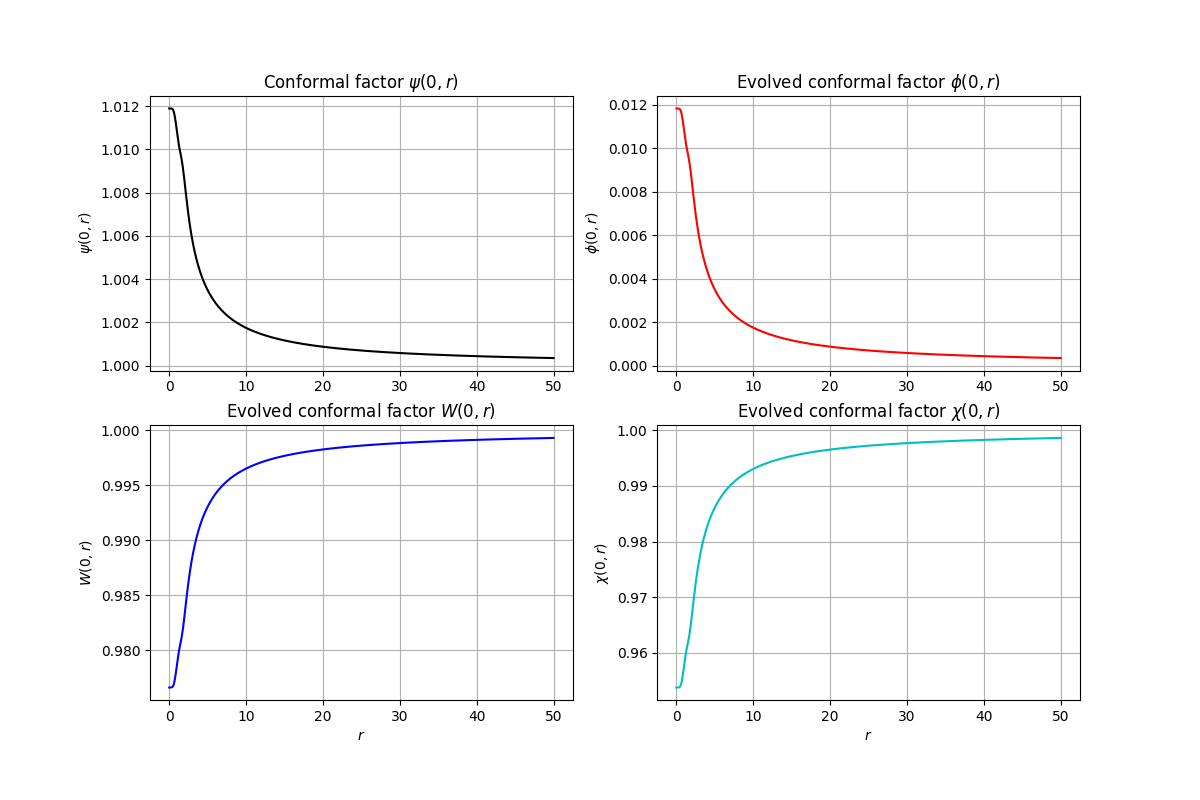

In [9]:
import matplotlib.pyplot as plt

# Compute phi
phi = np.log(psi)

# Compute W
W = psi**(-2)

# Compute chi
chi = psi**(-4)

f = plt.figure(figsize=(12,8),dpi=100)

ax  = f.add_subplot(221)
ax.set_title(r"Conformal factor $\psi(0,r)$")
ax.set_ylabel(r"$\psi(0,r)$")
ax.plot(r,psi,'k-')
ax.grid()

ax2 = f.add_subplot(222)
ax2.set_title(r"Evolved conformal factor $\phi(0,r)$")
ax2.set_ylabel(r"$\phi(0,r)$")
ax2.plot(r,phi,'r-')
ax2.grid()

ax3 = f.add_subplot(223)
ax3.set_title(r"Evolved conformal factor $W(0,r)$")
ax3.set_xlabel(r"$r$")
ax3.set_ylabel(r"$W(0,r)$")
ax3.plot(r,W,'b-')
ax3.grid()

ax4 = f.add_subplot(224)
ax4.set_title(r"Evolved conformal factor $\chi(0,r)$")
ax4.set_xlabel(r"$r$")
ax4.set_ylabel(r"$\chi(0,r)$")
ax4.plot(r,chi,'c-')
ax4.grid()

outfile = os.path.join(Ccodesdir,"cfs_scalarfield_id.png")
plt.savefig(outfile)
plt.close(f)

# Display the figure
from IPython.display import Image
Image(outfile)

<a id='id_lapse_function'></a>

## Step 1.d The lapse function: $\tilde\alpha$ \[Back to [top](#toc)\]
$$\label{id_lapse_function}$$

There are two common initial conditions for $\tilde\alpha$. The first one is eq. (44) of [A&C](https://arxiv.org/pdf/1508.01614.pdf), namely setting the lapse to unity

$$
\tilde\alpha = 1\ .
$$

In [10]:
# Set the unity lapse initial condition
alpha_unity = np.ones(NR)

The second one is discussed in the last paragraph of section II.B in [Baumgarte](https://arxiv.org/pdf/1807.10342.pdf), which is to set the "pre-collapsed lapse"

$$
\tilde\alpha = \psi^{-2}\ .
$$

In [11]:
# Set the "pre-collapsed lapse" initial condition
alpha_precollapsed = psi**(-2)

<a id='id_output'></a>

## Step 1.e Outputting the initial data to file \[Back to [top](#toc)\]
$$\label{id_output}$$

In [12]:
# Check to see which version of Python is being used
# For a machine running the final release of Python 3.7.1,
# sys.version_info should return the tuple [3,7,1,'final',0]
if sys.version_info[0] == 3:
    np.savetxt(os.path.join(Ccodesdir,"outputSFID_unity_lapse.txt"), list(zip( r, ID_sf, psi**4, alpha_unity )),
               fmt="%.15e")
    np.savetxt(os.path.join(Ccodesdir,"outputSFID_precollapsed_lapse.txt"), list(zip( r, ID_sf, psi**4, alpha_precollapsed )),
               fmt="%.15e")


elif sys.version_info[0] == 2:
    np.savetxt(os.path.join(Ccodesdir,"outputSFID_unity_lapse.txt"), zip( r, ID_sf, psi**4, alpha_unity ),
               fmt="%.15e")
    np.savetxt(os.path.join(Ccodesdir,"outputSFID_precollapsed_lapse.txt"), zip( r, ID_sf, psi**4, alpha_precollapsed ),
               fmt="%.15e")

<a id='id_interpolation_files'></a>

# Step 2: Interpolating the initial data file as needed \[Back to [top](#toc)\]
$$\label{id_interpolation_files}$$

In order to use the initial data file properly, we must tell the program how to interpolate the values we just computed to the values of $r$ in our numerical grid. We do this by creating two C functions: one that interpolates the ADM quantities, $\left\{\gamma_{ij},K_{ij},\alpha,\beta^{i},B^{i}\right\}$, and one that interpolates the scalar field quantities, $\left\{\varphi,\Pi\right\}$. The two files written below use the scalar_field_interpolate_1D(  ) function, which is defined in the [ScalarField/ScalarField_interp.h](../edit/ScalarField/ScalarField_interp.h) file. This function performs a Lagrange polynomial interpolation between the initial data file and the numerical grid used during the simulation.

In [13]:
with open(os.path.join(Ccodesdir,"ID_scalar_field_ADM_quantities-validation.h"), "w") as file:
    file.write("""
// This function takes as input either (x,y,z) or (r,th,ph) and outputs
//   all ADM quantities in the Cartesian or Spherical basis, respectively.
void ID_scalar_field_ADM_quantities(
                     const REAL xyz_or_rthph[3],

                     const ID_inputs other_inputs,

                     REAL *gammaDD00,REAL *gammaDD01,REAL *gammaDD02,REAL *gammaDD11,REAL *gammaDD12,REAL *gammaDD22,
                     REAL *KDD00,REAL *KDD01,REAL *KDD02,REAL *KDD11,REAL *KDD12,REAL *KDD22,
                     REAL *alpha,
                     REAL *betaU0,REAL *betaU1,REAL *betaU2,
                     REAL *BU0,REAL *BU1,REAL *BU2) {

      const REAL r  = xyz_or_rthph[0];
      const REAL th = xyz_or_rthph[1];
      const REAL ph = xyz_or_rthph[2];

      REAL sf_star,psi4_star,alpha_star;

      scalar_field_interpolate_1D(r,
                                  other_inputs.interp_stencil_size,
                                  other_inputs.numlines_in_file,
                                  other_inputs.r_arr,
                                  other_inputs.sf_arr,
                                  other_inputs.psi4_arr,
                                  other_inputs.alpha_arr,
                                  &sf_star,&psi4_star,&alpha_star);

      // Update alpha
      *alpha = alpha_star;
      // \gamma_{rr} = psi^4
      *gammaDD00 = psi4_star;
      // \gamma_{thth} = psi^4 r^2
      *gammaDD11 = psi4_star*r*r;
      // \gamma_{phph} = psi^4 r^2 sin^2(th)
      *gammaDD22 = psi4_star*r*r*sin(th)*sin(th);

      // All other quantities ARE ZERO:
      *gammaDD01 = 0.0; *gammaDD02 = 0.0;
      /**/              *gammaDD12 = 0.0;

      *KDD00 = 0.0; *KDD01 = 0.0; *KDD02 = 0.0;
      /**/          *KDD11 = 0.0; *KDD12 = 0.0;
      /**/                        *KDD22 = 0.0;

      *betaU0 = 0.0; *betaU1 = 0.0; *betaU2 = 0.0;

      *BU0 = 0.0; *BU1 = 0.0; *BU2 = 0.0;
}\n""")

with open(os.path.join(Ccodesdir,"ID_scalar_field_spherical-validation.h"), "w") as file:
    file.write("""
    void ID_scalarfield_spherical(
                     const REAL xyz_or_rthph[3],
                     const ID_inputs other_inputs,
                     REAL *sf, REAL *sfM) {

      const REAL r  = xyz_or_rthph[0];
      const REAL th = xyz_or_rthph[1];
      const REAL ph = xyz_or_rthph[2];

      REAL sf_star,psi4_star,alpha_star;

      scalar_field_interpolate_1D(r,
                                  other_inputs.interp_stencil_size,
                                  other_inputs.numlines_in_file,
                                  other_inputs.r_arr,
                                  other_inputs.sf_arr,
                                  other_inputs.psi4_arr,
                                  other_inputs.alpha_arr,
                                  &sf_star,&psi4_star,&alpha_star);

      // Update varphi
      *sf  = sf_star;
      // Update Pi
      *sfM = 0;

}\n""")

<a id='id_sph_to_curvilinear'></a>

# Step 3: Converting Spherical initial data to Curvilinear initial data \[Back to [top](#toc)\]
$$\label{id_sph_to_curvilinear}$$

In this tutorial module we have explained how to obtain spherically symmetric, time-symmetric initial data for the collapse of a massless scalar field in Spherical coordinates (see [Step 1](#initial_data)). We have also explained how to interpolate the initial data file to the numerical grid we will use during the simulation (see [Step 2](#id_interpolation_files)).

NRPy+ is capable of generating the BSSN evolution equations in many different Curvilinear coordinates (for example SinhSpherical coordinates, which are of particular interest for this problem). Therefore, it is essential that we convert the Spherical initial data generated here to any Curvilinear system supported by NRPy+.

We start by calling the reference_metric() function within the [reference_metric.py](../edit/reference_metric.py) NRPy+ module. This will set up a variety of useful quantities for us.

In [14]:
import reference_metric as rfm
import NRPy_param_funcs as par

# Set the Curvilinear reference system to SinhSpherical
par.set_parval_from_str("reference_metric::CoordSystem",CoordSystem)

# Call the reference_metric() function
rfm.reference_metric()

Then the code below interpolate the values of the Spherical grid $\left\{r,\theta,\phi\right\}$ to the Curvilinear grid $\left\{{\rm xx0,xx1,xx2}\right\}$.

In [15]:
from outputC import *
import sympy as sp
sfSphorCart, sfMSphorCart = sp.symbols("sfSphorCart sfMSphorCart")

pointer_to_ID_inputs=False

r_th_ph_or_Cart_xyz_oID_xx = []
CoordSystem_in = "Spherical"

if CoordSystem_in == "Spherical":
    r_th_ph_or_Cart_xyz_oID_xx = rfm.xxSph
else:
    print("Error: Can only convert scalar field Spherical initial data to BSSN Curvilinear coords.")
    exit(1)

with open(os.path.join(Ccodesdir,"ID_scalarfield_xx0xx1xx2_to_BSSN_xx0xx1xx2-validation.h"), "w") as file:
    file.write("void ID_scalarfield_xx0xx1xx2_to_BSSN_xx0xx1xx2(const paramstruct *restrict params,const REAL xx0xx1xx2[3],")
    if pointer_to_ID_inputs == True:
        file.write("ID_inputs *other_inputs,")
    else:
        file.write("ID_inputs other_inputs,")
    file.write("""
                    REAL *restrict sf, REAL *restrict sfM ) {
#include \"set_Cparameters.h\"

      REAL sfSphorCart,sfMSphorCart;
      const REAL xx0 = xx0xx1xx2[0];
      const REAL xx1 = xx0xx1xx2[1];
      const REAL xx2 = xx0xx1xx2[2];
      REAL xyz_or_rthph[3];\n""")
outCparams = "preindent=1,outCfileaccess=a,outCverbose=False,includebraces=False"
outputC(r_th_ph_or_Cart_xyz_oID_xx[0:3], ["xyz_or_rthph[0]", "xyz_or_rthph[1]", "xyz_or_rthph[2]"],
        os.path.join(Ccodesdir,"ID_scalarfield_xx0xx1xx2_to_BSSN_xx0xx1xx2-validation.h"), outCparams + ",CSE_enable=False")

with open(os.path.join(Ccodesdir,"ID_scalarfield_xx0xx1xx2_to_BSSN_xx0xx1xx2-validation.h"), "a") as file:
    file.write("""ID_scalarfield_spherical(xyz_or_rthph, other_inputs,
                      &sfSphorCart, &sfMSphorCart);
        // Next compute all rescaled BSSN curvilinear quantities:\n""")
outCparams = "preindent=1,outCfileaccess=a,outCverbose=False,includebraces=False"
outputC([sfSphorCart, sfMSphorCart], ["*sf", "*sfM"],
        os.path.join(Ccodesdir,"ID_scalarfield_xx0xx1xx2_to_BSSN_xx0xx1xx2-validation.h"), params=outCparams)

with open(os.path.join(Ccodesdir,"ID_scalarfield_xx0xx1xx2_to_BSSN_xx0xx1xx2-validation.h"), "a") as file:
    file.write("}\n")

Appended to file "ScalarFieldID_validation/ID_scalarfield_xx0xx1xx2_to_BSSN_xx0xx1xx2-validation.h"
Appended to file "ScalarFieldID_validation/ID_scalarfield_xx0xx1xx2_to_BSSN_xx0xx1xx2-validation.h"


Finally, we create the driver function which puts everything together using OpenMP.

In [16]:
import loop as lp

# Driver
with open(os.path.join(Ccodesdir,"ID_scalarfield-validation.h"), "w") as file:
    file.write("""void ID_scalarfield(const paramstruct *restrict params,REAL *restrict xx[3],
                                          ID_inputs other_inputs,REAL *restrict in_gfs) {
#include \"set_Cparameters.h\"\n""")
    file.write(lp.loop(["i2", "i1", "i0"], ["0", "0", "0"],
                       ["Nxx_plus_2NGHOSTS2", "Nxx_plus_2NGHOSTS1", "Nxx_plus_2NGHOSTS0"],
                       ["1", "1", "1"], ["#pragma omp parallel for",
                                         "    const REAL xx2 = xx[2][i2];",
                                         "        const REAL xx1 = xx[1][i1];"], "",
                           """const REAL xx0 = xx[0][i0];
const int idx = IDX3S(i0,i1,i2);
const REAL xx0xx1xx2[3] = {xx0,xx1,xx2};
ID_scalarfield_xx0xx1xx2_to_BSSN_xx0xx1xx2(params,xx0xx1xx2,other_inputs,
                    &in_gfs[IDX4ptS(SFGF,idx)],&in_gfs[IDX4ptS(SFMGF,idx)]);\n}\n"""))

<a id='validation'></a>

# Step 4: Validation of this tutorial against the [ScalarField/ScalarField_InitialData.py](../edit/ScalarField/ScalarField_InitialData.py) module \[Back to [top](#toc)\]
$$\label{validation}$$

First we load the [ScalarField/ScalarField_InitialData.py](../edit/ScalarField/ScalarField_InitialData.py) module and compute everything by using the scalarfield_initial_data(  ) function, which should do exactly the same as we have done in this tutorial.

In [17]:
# Import the ScalarField.ScalarField_InitialData NRPy module
import reference_metric as rfm
import NRPy_param_funcs as par
import ScalarField.ScalarField_InitialData as sfid

# Output the unity lapse initial data file
outputname = os.path.join(Ccodesdir,"outputSFID_unity_lapse-validation.txt")
sfid.ScalarField_InitialData(outputname, Ccodesdir,ID_Family,
                             phi0,r0,sigma,NR,RMAX,lapse_condition="Unity",
                             CoordSystem=CoordSystem,sinhA=sinhA,sinhW=sinhW)

# Output the "pre-collapsed" lapse initial data file
outputname = os.path.join(Ccodesdir,"outputSFID_precollapsed_lapse-validation.txt")
sfid.ScalarField_InitialData(outputname, Ccodesdir,ID_Family,
                             phi0,r0,sigma,NR,RMAX,lapse_condition="Pre-collapsed",
                             CoordSystem=CoordSystem,sinhA=sinhA,sinhW=sinhW)

Generated the ADM initial data for the gravitational collapse 
of a massless scalar field in Spherical coordinates.

Type of initial condition: Scalar field: "Gaussian" Shell
                         ADM quantities: Time-symmetric
                        Lapse condition: Unity
Parameters: amplitude         = 0.1,
            center            = 0,
            width             = 1,
            domain size       = 50,
            number of points  = 30000,
            Initial data file = ScalarFieldID_validation/outputSFID_unity_lapse-validation.txt.

Wrote to file ScalarFieldID_validation/ID_scalar_field_ADM_quantities.h
Wrote to file ScalarFieldID_validation/ID_scalar_field_spherical.h
Appended to file "ScalarFieldID_validation/ID_scalarfield_xx0xx1xx2_to_BSSN_xx0xx1xx2.h"
Appended to file "ScalarFieldID_validation/ID_scalarfield_xx0xx1xx2_to_BSSN_xx0xx1xx2.h"
Generated the ADM initial data for the gravitational collapse 
of a massless scalar field in Spherical coordinates.

Type of i

In [18]:
import filecmp

if filecmp.cmp(os.path.join(Ccodesdir,'outputSFID_unity_lapse.txt'),
               os.path.join(Ccodesdir,'outputSFID_unity_lapse-validation.txt')) == False:
    print("ERROR: Unity lapse initial data test FAILED!")
    exit(1)
else:
    print("             Unity lapse initial data test: PASSED!")

if filecmp.cmp(os.path.join(Ccodesdir,'outputSFID_precollapsed_lapse.txt'),
               os.path.join(Ccodesdir,'outputSFID_precollapsed_lapse-validation.txt')) == False:
    print("ERROR: \"Pre-collapsed\" lapse initial data test FAILED!")
    exit(1)
else:
    print("   \"Pre-collapsed\" lapse initial data test: PASSED!")

if filecmp.cmp(os.path.join(Ccodesdir,'ID_scalar_field_ADM_quantities.h'),
               os.path.join(Ccodesdir,'ID_scalar_field_ADM_quantities-validation.h')) == False:
    print("ERROR: ADM quantities interpolation file test FAILED!")
    exit(1)
else:
    print("    ADM quantities interpolation file test: PASSED!")

if filecmp.cmp(os.path.join(Ccodesdir,'ID_scalar_field_spherical.h'),
               os.path.join(Ccodesdir,'ID_scalar_field_spherical-validation.h')) == False:
    print("ERROR: Scalar field interpolation file test FAILED!")
    exit(1)
else:
    print("      Scalar field interpolation file test: PASSED!")

if filecmp.cmp(os.path.join(Ccodesdir,'ID_scalarfield_xx0xx1xx2_to_BSSN_xx0xx1xx2.h'),
               os.path.join(Ccodesdir,'ID_scalarfield_xx0xx1xx2_to_BSSN_xx0xx1xx2-validation.h')) == False:
    print("ERROR: Scalar field Spherical to Curvilinear test FAILED!")
    exit(1)
else:
    print("Scalar field Spherical to Curvilinear test: PASSED!")

if filecmp.cmp(os.path.join(Ccodesdir,'ID_scalarfield.h'),
               os.path.join(Ccodesdir,'ID_scalarfield-validation.h')) == False:
    print("ERROR: Scalar field driver test: FAILED!")
    exit(1)
else:
    print("                  Scalar field driver test: PASSED!")

             Unity lapse initial data test: PASSED!
   "Pre-collapsed" lapse initial data test: PASSED!
    ADM quantities interpolation file test: PASSED!
      Scalar field interpolation file test: PASSED!
Scalar field Spherical to Curvilinear test: PASSED!
                  Scalar field driver test: PASSED!


<a id='output_to_pdf'></a>

# Step 5: Output this module as $\LaTeX$-formatted PDF file \[Back to [top](#toc)\]
$$\label{output_to_pdf}$$

The following code cell converts this Jupyter notebook into a proper, clickable $\LaTeX$-formatted PDF file. After the cell is successfully run, the generated PDF may be found in the root NRPy+ tutorial directory, with filename
[Tutorial-ADM_Initial_Data-ScalarField.pdf](Tutorial-ADM_Initial_Data-ScalarField.pdf) (Note that clicking on this link may not work; you may need to open the PDF file through another means.)

In [19]:
import cmdline_helper as cmd    # NRPy+: Multi-platform Python command-line interface
cmd.output_Jupyter_notebook_to_LaTeXed_PDF("Tutorial-ADM_Initial_Data-ScalarField")

Created Tutorial-ADM_Initial_Data-ScalarField.tex, and compiled LaTeX file
    to PDF file Tutorial-ADM_Initial_Data-ScalarField.pdf
